Load needed libraries:

In [114]:
import numpy as np
from scipy.io import loadmat
from scipy.stats import zscore
import matplotlib.pyplot as plt
from matplotlib import cm

In [143]:
# load and zscore time series
z_ts=zscore(loadmat('/home/vicente/event_detection/ts.mat')['ts'])
# Get number of time points/nodes
[t,n] =z_ts.shape
# upper triangle indices (node pairs = edges)
u,v= np.argwhere(np.triu(np.ones(n),1)).T

# edge time series
ets = z_ts[:,u]*z_ts[:,v]

# calculate rss
#rss = sum(ets.^2,2).^0.5;
rss = np.sqrt(np.sum(np.square(ets), axis=1))

(818, 333)

In [68]:
# repeat with randomized time series
numrand = 100;
# initialize array for null rss
rssr = np.zeros([t,numrand]);

# perform numrand randomizations
for irand in range(numrand):
    # create circularly shifted time series
    zr = z_ts;
    for i in range(n):
        zr[:,i] = np.roll(zr[:,i],np.random.randint(t))
    
    # edge time series with circshift data
    etsr = zr[:,u]*zr[:,v]
    
    # calcuate rss
    rssr[:,irand] = np.sqrt(np.sum(np.square(etsr), axis=1))


In [92]:
# calculate p-value
p = np.zeros([t,1]);
for i in range(t):
    p[i] = np.mean(np.reshape(rssr,rssr.shape[0]*rssr.shape[1]) >= rss[i])
# apply statistical cutoff
pcrit = 0.001

# find frames that pass statistical test
idx = np.argwhere(p < pcrit)[:,0]

# identify contiguous segments of frames that pass statistical test
dff = idx.T - range(len(idx))
unq = np.unique(dff)
nevents = len(unq)

# find the peak rss within each segment
idxpeak = np.zeros([nevents,1]);
for ievent in range(nevents):
    idxevent = idx[dff.T == unq[ievent].T]
    rssevent = rss[idxevent]
    idxmax = np.argmax(rssevent)
    idxpeak[ievent] = idxevent[idxmax]
idxpeak=idxpeak[:,0].astype(int)
# get activity at peak
tspeaks = z_ts[idxpeak,:]

# get co-fluctuation at peak
etspeaks = tspeaks[:,u]*tspeaks[:,v]

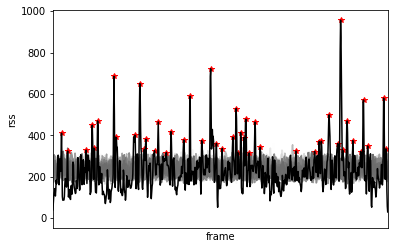

In [142]:
# plot rss time series, null, and significant peaks
greymap = cm.get_cmap('Greys')
colors=greymap(np.linspace(0,0.65,rssr.shape[1]))
plt.figure()
for i in range(rssr.shape[1]):
    ph=plt.plot(range(t),rssr[:,i],color=colors[i]);
qh=plt.plot(idxpeak,rss[idxpeak],'r*',range(t),rss,'k','linewidth',2);
plt.xlim([1,t])
plt.xlabel('frame'); 
plt.ylabel('rss');
# plt.legend([ph[0], qh],['null','significant','orig']);

In [163]:
# calculate mean co-fluctuation (edge time series) across all peaks
mu = np.nanmean(etspeaks,0);

# represent in matrix form
mat = np.zeros([n,n]);
mat[np.triu(np.ones([n,n]),1) > 0] = mu;
mat = mat + mat.T;

(333, 333)

KeyError: 'sequential'